1. Создаем датафрейм с названием фильма, уровнем и названием файла с субтитрами
    * Удаляем лишние столбцы
    * Применяем `.strip()` к названию фильмов (там были переносы строк)
    * Заменяем `/` на `_` в названии уровней для корректной работы path строк.
    * Собираем список файлов с субтитрами с помощью `os.listdir()`
    * С помощью `difflib.get_close_matches()` создаем столбец с названиями файлов субтитров
2. Создадим из каждого субтитра plain text (.txt) с помощью `pysubs2` в отдельной папке
3. Распределим txt по подпапкам с уровнем сложности для корректной работы `sklearn.datasets.load_files`
4. Извлечение мета информации из субтитров (распределение скорости показа, распределение длинны предложений) [**TO DO**]
5. Предобработка словаря
    * Оставим записи с только 1 словом
    * И записи принадлежащие только 1 уровню, а не нескольким сразу (см. раздел)
    1. Удаление спец. символов и цифр `re.sub("(\\W|\\d)","",x)`
    2. Приведение к нижнему регистру `.lower()`
    3. `nltk.stem.WordNetLemmatizer`
6. Ф-ции токенизации и лемматизации текста with `spaCy`
7. Исследование уровней [**ONGOIN**]
8. Пайплайн для тренировки логистической регрессии [**RAW**]
9. Оценка моделей бинарной классификации для каждого уровня [**RAW**]

## Создаем датафрейм с названием фильма, уровнем и названием файла с субтитрами

In [1]:
import warnings
import os
import shutil
import pathlib

import difflib

import pandas as pd

import pysubs2

import re

import spacy


In [2]:
def labels_preproc(path):
    labels = pd.read_csv(path)
    # labels.columns
    labels = labels.drop(columns=['Kinopoisk ','Subtitles'])
    labels = labels.sort_values('Movie').reset_index(drop=True)

    labels['Movie'] = labels['Movie'].str.strip()

    # with pd.option_context("display.max_rows", 300):
    #     display(labels['Movie'])
    # labels['Movie'].unique()
    # labels['Level'].value_counts()

    labels.loc[labels['Level'] == 'A2/A2+','Level'] = 'A2_A2+'
    # labels.loc[labels['Level'] == 'B1, B2','Level'] = 'A2_A2+'
    labels.loc[labels['Level'] == 'A2/A2+, B1','Level'] = 'A2_A2+, B1'
    return labels

labels = labels_preproc('data/labels.csv')
# labels.head()

In [3]:
def add_subs_file_names(df,path_to_raw_subs):
    # Список уже имеющихся субтитров
    subs_file_list = os.listdir(path_to_raw_subs)
    # subs_file_list = [x.lower() for x in subs_file_list]
    # subs_file_list[:5]
    # labels.head(1)

    # Присваиваем название субтитра по наибольшему совпадению
    for movie in df['Movie']:
        df.loc[df['Movie'] == movie,'sub_file_name'] = difflib.get_close_matches(movie, subs_file_list,cutoff=0)[0]
        
    return df
        
labels = add_subs_file_names(labels,'data/Subtitles_raw/')
labels = labels.drop(index=[39,61]) # Удаляем сериалы
labels.loc[labels['Movie'] == 'Harry Potter (1)', 'sub_file_name'] = 'Harry_Potter_and_the_philosophers_stone(2001).srt'
labels = labels.reset_index(drop=True)

In [4]:

# with pd.option_context("display.max_rows", 300):
#     display(labels)

## Создадим из каждого субтитра plain text (.txt) с помощью `pysubs2` в отдельной папке

Удалить HTML теги просто
https://stackoverflow.com/questions/753052/strip-html-from-strings-in-python#:~:text=If%20you%20need%20to%20strip%20HTML

In [5]:
def create_plain_text_str(sub_file,delete_html_tags=True):
    plain_text = ''
    for line in sub_file:  
        # plain_text += line.plaintext + ' '
        plain_text += line.text + ' '
    
    # Удаление HTML тегов перенесли в предобработку.
    # Нужно помнить, что при открытии файла pysubs2.load
    # keep_html_tags должен быть True
    # if delete_html_tags:
    #     plain_text = re.sub('<[^<]+?>', ' ', plain_text)
        
    return plain_text


# subs = pysubs2.load('data/Subtitles_raw/10_Cloverfield_lane(2016).srt',
#                     # keep_html_tags=False,
#                     keep_unknown_html_tags=True
#                    )

# test = create_plain_text_str(subs)
# test

In [6]:
def create_plain_text_files(df, dir_with_subs,dir_with_txt):
    pwd = os.path.abspath(os.getcwd())
    path_from = os.path.join(pwd, dir_with_subs)
    path_to = os.path.join(pwd, dir_with_txt)
    
    try:
        os.mkdir(path_to)
    except:
        print(dir_with_txt, ' already exists. But that\'s fine')
        
    for i in range(len(labels)):
        
        
        sub_name = labels.iloc[i]['sub_file_name']
        
        path_to_sub_file = os.path.join(path_from,sub_name)
      
        sub_obj = pysubs2.load(path_to_sub_file,keep_html_tags=True)
        
        plain_text = create_plain_text_str(sub_obj)
        
        plain_text_name = sub_name + '.txt'
        # print(plain_text_name)
        path_to_plain_text_file = os.path.join(path_to,plain_text_name)
        
        
        with open(path_to_plain_text_file, "w",encoding="utf-8") as file:
            # Writing data to a file
            file.write(plain_text)
    
# create_plain_text_files(labels, 'data\Subtitles_raw','data\Subtitles_plain_text')

## Распределим txt по подпапкам с уровнем сложности для корректной работы `sklearn.datasets.load_files`

In [7]:
# Это мультклассовая разбивка
# Еще стоит разделить на бинарные задачи

def distribute_into_level_subfolders(labels,dir_with_txt_files,dir_with_level_subfolders):
    pwd = os.path.abspath(os.getcwd())
    path_from = os.path.join(pwd, dir_with_txt_files)
    path_to = os.path.join(pwd, dir_with_level_subfolders)
    # print(path_from)
    # print(path_to)
    
    try:
        os.mkdir(path_to)
    except:
        print(dir_with_level_subfolders, ' already exists. But that\'s fine')
        
    for i in range(len(labels)):
        level = labels.iloc[i]['Level']
        txt_name = labels.iloc[i]['sub_file_name'] + '.txt'
        
        # print(level,txt_name)
        
        path_from_ = os.path.join(path_from,txt_name)
        path_to_level = os.path.join(path_to,level)
        path_to_file = os.path.join(path_to_level,txt_name)

        # print(path_from_)
        # print(path_to_)
        try:
            shutil.copy(path_from_, path_to_file)
        except:
            os.mkdir(path_to_level)
            shutil.copy(path_from_, path_to_file)
    
# distribute_into_level_subfolders(labels,'data\Subtitles_plain_text','data\Subtitles_multiclass')

In [8]:
# Это мульти бинарная разбивка
# Тут столько задач классификации, сколько уровней
# По принципу определения А1 уровень и не А1 уровень
# И так по каждому уровню

def distribute_into_multi_binary_subfolders(labels,dir_with_txt_files,dir_with_multi_binary_subfolders):
    pwd = os.path.abspath(os.getcwd())
    path_from = os.path.join(pwd, dir_with_txt_files)
    path_to = os.path.join(pwd, dir_with_multi_binary_subfolders)
    # print(path_from)
    # print(path_to)
    
#     Создаем папку где будут лежать каждая из классификаций
    try:
        os.mkdir(path_to)
    except:
        print(dir_with_multi_binary_subfolders, ' already exists. But that\'s fine')
    
    for level in labels['Level'].unique():
        
#         Берем уровень

#         Берем субитры этого уровня
        the_level = labels.loc[labels['Level'] == level,'sub_file_name']
        the_level = the_level + '.txt'
        # display(the_level)
        
        # Берем путь до папки где будут располагаться категории
        path_to_level = os.path.join(path_to,level)
        # print(path_to_level)
        
        # Размещаться они будут так:
        #     B1/B1
        #     B1/not_B1
        
        # Пробуем создать папку с категорией контретного уровня 
        try:
            os.mkdir(path_to_level)
        except:
            print(path_to_level, ' already exists. But that\'s fine')        
        
        
        for txt in the_level:
            # Каждый субтитр этого уровня переносим в папку вида B1/B1
            path_from_file = os.path.join(path_from,txt)
            # print(path_from_file)
            path_to_level_level = os.path.join(path_to_level,level)
            path_to_file = os.path.join(path_to_level_level,txt)
            # print(path_to_file)
            try:
                shutil.copy(path_from_file, path_to_file)
            except:
                os.mkdir(path_to_level_level)
                shutil.copy(path_from_file, path_to_file)
            
            # try:
            #     os.mkdir
        
        # Берем субтитры не этого уровня
        not_level = labels.loc[labels['Level'] != level,'sub_file_name']
        not_level = not_level + '.txt'
        
        for txt in not_level:
            # Каждый этот субтитр переносим в папку вида B1/not_B1
            path_from_file = os.path.join(path_from,txt)
            # print(path_from_file)
            path_to_level_level = os.path.join(path_to_level,'not_' + level)
            path_to_file = os.path.join(path_to_level_level,txt)
            # print(path_to_file)    
            
            try:
                shutil.copy(path_from_file, path_to_file)
            except:
                os.mkdir(path_to_level_level)
                shutil.copy(path_from_file, path_to_file)
        
        

    
# distribute_into_multi_binary_subfolders(labels,'data\Subtitles_plain_text','data\Subtitles_multi_binary')

## Извлечение мета информации из субтитров (распределение скорости показа, распределение длинны предложений) `[TO DO]`

Для создания распределения скорости показа нужно время показа субтитра (`end_time - start_time`) разделить на кол-во символов в конкретном субтитре. Делается это с помощью `pysubs2`.

Для создания распределения длинны предложений нужно обработанные субтитры в виде текста (`.txt`) разделить на предложения и посчитать кол-во слов (или напр. кол-во пробелов +1). Эта же процедура позволит посчитать кол-во предложений.

## Предобработка словаря

In [9]:

# vocab = pd.read_json('vocab/worddata.json')
## vocab = pd.json_normalize('vocab/worddata.json')



# vocab
# vocab[vocab['baseword'] == 'and']
# Что такое `'guideword'` и как обрабатывать, что одно слово принадлежит разным уровням?
# vocab['level'].value_counts()

# Нам не нужны уровни выше B2, поэтому обрежем.
# vocab['level'].sort_values().unique().tolist()

# levels = ['A1', 'A2', 'B1', 'B2']

# vocab.loc[vocab['level'].isin(levels)].count()

# vocab = vocab.loc[vocab['level'].isin(levels)]

# vocab
# test = vocab.groupby('baseword')['level'].unique()
# pd.DataFrame(test).head(50)

# with pd.option_context("display.max_rows", 300):
#     display(pd.DataFrame(test))

# stopwords.words('english')

In [10]:
vocab = pd.read_json('vocab/englishprofile.json')
vocab.head()

,baseword,guideword,level,partofspeech,topic,url
0,cattle,None,B1,None,animals,/british-english/words/detail/817
1,clothes,None,A1,None,clothes,/british-english/words/detail/972
2,albeit,None,C2,None,None,/british-english/words/detail/157
3,and,ALSO,A1,None,communication,/british-english/words/detail/229
4,and,AFTER,A1,None,communication,/british-english/words/detail/229


Нам понадобится только `'baseword'` и `'level'`.   
Обратим внимание, что 1 `'baseword'` может принадлежать нескольким уровням.  
1. Сгруппируем по `'baseword'` и возьмем `.unique()` от `'level'`
2. Предобработам `'baseword'`, чтобы в дальнейшем использовать в качестве словаря для `CountVectorizer` и для исследования распределений слов и уровней.
3. Решим как работать со словами, принадлежащими многим уровням

In [11]:
vocab_grouped = pd.DataFrame(vocab.groupby('baseword')['level'].unique())
vocab_grouped = vocab_grouped.reset_index()
vocab_grouped.head()

,baseword,level
0,all along,[B2]
1,all in all,[B2]
2,all of a sudden,[B2]
3,be used to sb/sth/doing sth,[B1]
4,bound to do sth,[B2]


In [12]:
vc = vocab_grouped['level'].value_counts()


In [13]:
vc[:7]

[B2]        2195
[C2]        2085
[B1]        1352
[C1]        1338
[A2]         693
[A1]         326
[B1, B2]       1
Name: level, dtype: int64

Пока будем использовать слова, принадлежащие только 1 уровню, а не многим сразу.

In [14]:
vocab_grouped['level'] = vocab_grouped['level'].apply(lambda x: ''.join(x))
vocab_grouped = vocab_grouped[vocab_grouped['level'].isin(['A1','A2','B1','B2','C1','C2'])]

In [15]:
vocab_grouped

,baseword,level
0,all along,B2
1,all in all,B2
2,all of a sudden,B2
3,be used to sb/sth/doing sth,B1
4,bound to do sth,B2
...,...,...
9757,youth,B1
9758,zebra,B2
9760,zip,B2
9761,zone,B1


In [16]:
vocab_grouped['word_count'] = vocab_grouped['baseword'].str.split().apply(lambda x: len(x))

In [17]:
vocab_grouped.head()

,baseword,level,word_count
0,all along,B2,2
1,all in all,B2,3
2,all of a sudden,B2,4
3,be used to sb/sth/doing sth,B1,5
4,bound to do sth,B2,4


Оставим слова, где только 1 слово.

In [18]:
vocab_grouped = vocab_grouped[vocab_grouped['word_count'] == 1]

In [19]:
vocab_grouped.head()

,baseword,level,word_count
49,Absolutely!,C1,1
51,April,A1,1
52,August,A1,1
53,CD,A1,1
55,CD-ROM,B1,1


Удалим символы и знаки препинания.

In [20]:
vocab_grouped.loc[:,'baseword'] = vocab_grouped['baseword'].apply(lambda x: re.sub("(\\W|\\d)","",x))
vocab_grouped.head()

C:\Users\SnakeRZR\AppData\Local\Temp\ipykernel_18352\3102664304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vocab_grouped.loc[:,'baseword'] = vocab_grouped['baseword'].apply(lambda x: re.sub("(\\W|\\d)","",x))


,baseword,level,word_count
49,Absolutely,C1,1
51,April,A1,1
52,August,A1,1
53,CD,A1,1
55,CDROM,B1,1


Приведем все к нижнему регистру.

In [21]:
vocab_grouped['baseword'] = vocab_grouped['baseword'].str.lower()

C:\Users\SnakeRZR\AppData\Local\Temp\ipykernel_18352\2602915212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vocab_grouped['baseword'] = vocab_grouped['baseword'].str.lower()


In [22]:
vocab_grouped.head()

,baseword,level,word_count
49,absolutely,C1,1
51,april,A1,1
52,august,A1,1
53,cd,A1,1
55,cdrom,B1,1


In [23]:
vocab_grouped = vocab_grouped.drop(columns=['word_count']).reset_index(drop=True)

In [24]:
import nltk
import pandas as pd
import re
# from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 

word_net = WordNetLemmatizer() 

vocab_grouped['baseword'] = vocab_grouped['baseword'].apply(lambda x: word_net.lemmatize(x))

In [25]:
vocab_grouped

,baseword,level
0,absolutely,C1
1,april,A1
2,august,A1
3,cd,A1
4,cdrom,B1
...,...,...
4873,youth,B1
4874,zebra,B2
4875,zip,B2
4876,zone,B1


In [26]:
vocab_grouped = vocab_grouped.drop_duplicates()

Создадим словарь в виде списка.

In [27]:
vocab_for_cvect = vocab_grouped['baseword'].unique().tolist()

In [28]:
# vocab_for_cvect

Для обработки словаря мы использовали:
1. Удаление спец. символов и цифр `re.sub("(\\W|\\d)","",x)`
2. Приведение к нижнему регистру `.lower()`
3. `nltk.stem.WordNetLemmatizer`

In [29]:
# Очистим `'baseword'` от самых встречающихся слов.
# cvect = CountVectorizer()
# vocab_string = ' '.join(vocab_grouped.index\
#                         # .apply(str_clean)
#                         # .apply(lemmatize_text)
#                         .unique().tolist())
# vocab_cvect = cvect.fit_transform([vocab_string])
# vocab_cvect = pd.DataFrame(vocab_cvect.toarray(),columns = cvect.get_feature_names_out()).T
# vocab_cvect.sort_values(0,ascending=False).head(50)

## Ф-ции токенизации и лемматизации текста
Для исследования уровней сложности английского языка с помощью словаря нам нужно привести текст в табличный вид.

In [30]:
# =====================
# НЕ ИСПОЛЬЗУЕМ
# =====================
def tokenize_for_wordnet(text:str) -> list:
    
    # Удаляем все html теги
    text = re.sub('<[^<]+?>', ' ', text)

    # Удалим . ? , '
    text = re.sub('(\.|\?|,|\')','',text)
    
    # Удаление оcтальных спец символов и цифр
    text = re.sub("(\\W|\\d)"," ",text)
    
    text = text.lower().split()
    
    return text

# path_to_sub_test = 'data/Subtitles_plain_text/10_Cloverfield_lane(2016).srt.txt'
# with open(path_to_sub_test, 'r') as f:
#     test_text = f.read()
    
# tokenize(test_text)[:1000]

In [31]:
# =====================
# НЕ ИСПОЛЬЗУЕМ
# =====================
def lemmatize_wordnet(token_list) -> list:
    # result = []
    word_net = WordNetLemmatizer() 
    result = [word_net.lemmatize(token) for token in token_list]
    return result

# path_to_sub_test = 'data/Subtitles_plain_text/10_Cloverfield_lane(2016).srt.txt'
# with open(path_to_sub_test, 'r') as f:
#     test_text = f.read()
    
# token_list =  tokenize(test_text)[:1000]

# lemmatize_wordnet(token_list)

Здесь последовательно 4 функции для токенизации и лемматизации текста с помощью `spaCy`.  
И 5 объединяющая.

In [32]:
def tokenize_for_spacy(text:str) -> str:
    
    # Удаляем все html теги
    text = re.sub('<[^<]+?>', ' ', text)

    # Удалим . ? , '
    # text = re.sub('(\.|\?|,|\')','',text)
    
    # Удалим '
    # text = re.sub('\'','',text)
    
    # Удаление оcтальных спец символов и цифр
    # text = re.sub("(\\W|\\d)"," ",text)
    
    text = text.lower()
    
    return text

# path_to_sub_test = 'data/Subtitles_plain_text/10_Cloverfield_lane(2016).srt.txt'
# with open(path_to_sub_test, 'r') as f:
#     test_text = f.read()

# test = tokenize_for_spacy(test_text)

In [33]:

def lemmatize_spacy(text:str,spacy_nlp) -> str:
    str_ = spacy_nlp(text)
    result = " ".join([token.lemma_ for token in str_])
    return result


# path_to_sub_test = 'data/Subtitles_plain_text/10_Cloverfield_lane(2016).srt.txt'
# with open(path_to_sub_test, 'r') as f:
#     test_text = f.read()
# test = tokenize_for_spacy(test_text)

# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# lemmatize_spacy(test,nlp)

In [34]:
def clean_up_for_spacy(text:str) -> str:
    # Удаление оcтальных спец символов и цифр
    text = re.sub("(\\W|\\d)"," ",text)
    return text

# path_to_sub_test = 'data/Subtitles_plain_text/10_Cloverfield_lane(2016).srt.txt'
# with open(path_to_sub_test, 'r') as f:
#     test_text = f.read()
# test = tokenize_for_spacy(test_text)
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# test = lemmatize_spacy(test,nlp)

# clean_up_for_spacy(test)

In [35]:
def final_split(text:str) -> list:
    return text.split()

# path_to_sub_test = 'data/Subtitles_plain_text/10_Cloverfield_lane(2016).srt.txt'
# with open(path_to_sub_test, 'r') as f:
#     test_text = f.read()
# test = tokenize_for_spacy(test_text)
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# test = lemmatize_spacy(test,nlp)
# test = clean_up_for_spacy(test)

# final_split(test)

In [36]:
def spacy_str_preproc(text,spacy_nlp) -> list:
    text = tokenize_for_spacy(text)
    text = lemmatize_spacy(text,spacy_nlp)
    text = clean_up_for_spacy(text)
    text = final_split(text)
    return text

# path_to_sub_test = 'data/Subtitles_plain_text/10_Cloverfield_lane(2016).srt.txt'
# with open(path_to_sub_test, 'r') as f:
#     test_text = f.read()

# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# spacy_str_preproc(test_text,nlp)

## Исследование уровней `[ONGOING]`

Цели:
1. Сравнить распределения кол-ва слов каждого уровня сложности в фильмах с различными таргетами (с помощью словаря)
2. Сравнить длинну предложений в фильмах разного уровня сложности
3. Сравнить скорость показа субтитров -//-
4. Сравнить кол-во слов не попавших в словарь их кол-во уникальных слов (`count` и `nunique`)

In [37]:
pwd = os.path.abspath(os.getcwd())
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

word_level_counts = pd.DataFrame()

for sub_txt_file in labels['sub_file_name']:
    # берем субтитр в виде текста
    # предобрабатываем его 
    # переводим в датафрейм
    # мерджим этот датафрейм со словарем (full outer)
    # группируем по уровню сложности слова и извлекаем count и nunique по baseword
    # то что не имеет уровня сложности относим к словам за его пределами (тоже важная статистика)
    
    
    path_to_sub_txt = os.path.join(pwd, 'data\\Subtitles_plain_text\\')
    path_to_sub_txt = os.path.join(path_to_sub_txt, sub_txt_file + '.txt')
    # print(path_to_sub_txt)
    
    with open(path_to_sub_txt, 'r') as f:
        sub_plain_text = f.read()
        
    sub_bag_of_words = spacy_str_preproc(sub_plain_text,nlp)
    # print(sub_bag_of_words)
    
    sub_bag_of_words = pd.DataFrame(sub_bag_of_words,columns=['baseword'])
    
    sub_bag_of_words = sub_bag_of_words.merge(vocab_grouped,how='left')#left_on=0,right_on='baseword')
    # display(sub_bag_of_words)
    
    
    # Melting и перевод в одну строку, для объединения с labels
    # display(sub_bag_of_words.groupby('level',dropna=False)['baseword'].agg(['count','nunique']))
    # test = sub_bag_of_words.groupby('level',dropna=False)['baseword'].agg(['count','nunique'])
    sub_word_count = sub_bag_of_words.groupby('level',dropna=False)['baseword'].agg(['count','nunique'])
    sub_word_count.index = sub_word_count.index.fillna('not_in_vocab')
    sub_word_count = pd.melt(sub_word_count,value_vars = ['count','nunique'],ignore_index=False)
    sub_word_count = sub_word_count.set_index([sub_word_count.index,sub_word_count['variable']])
    sub_word_count.index = ['_'.join(ind) for ind in sub_word_count.index.values]
    sub_word_count = sub_word_count.drop(columns=['variable']).T
    sub_word_count['sub_file_name'] = sub_txt_file
    word_level_counts = pd.concat([word_level_counts,sub_word_count])
    
    # break
    
word_level_counts = word_level_counts.reset_index(drop=True)
df = labels.merge(word_level_counts)

**Строку с кол-вом слов всего и уникальных слов нужно нормализовать по кол-ву слов в тексте!**

In [38]:
# test
# test2 = test.copy()
# test2.index = test.index.fillna('not_in_vocab')
# test2
# test3 = pd.melt(test2,value_vars = ['count','nunique'],ignore_index=False)
# # # test2
# test3 = test3.set_index([test3.index,test3['variable']])
# test3.index = ['_'.join(ind) for ind in test3.index.values]
# test3 = test3.drop(columns=['variable'])
# test3.T

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
df

,Movie,Level,sub_file_name,A1_count,A2_count,B1_count,B2_count,C1_count,C2_count,not_in_vocab_count,A1_nunique,A2_nunique,B1_nunique,B2_nunique,C1_nunique,C2_nunique,not_in_vocab_nunique
0,10 Cloverfield Lane,B1,10_Cloverfield_lane(2016).srt,487,328,180,133,17,50,4544,80,73,84,62,13,24,680
1,10 things I hate about you,B1,10_things_I_hate_about_you(1999).srt,759,527,243,159,41,53,7393,98,80,114,101,31,38,1096
2,A knight’s tale,B2,A_knights_tale(2001).srt,819,306,268,169,56,45,6189,91,72,97,83,28,35,1058
3,A star is born,B2,A_star_is_born(2018).srt,1310,1082,271,193,28,39,12489,113,94,90,62,14,17,1048
4,Aladdin,A2_A2+,Aladdin(1992).srt,675,471,336,186,52,54,7287,96,92,105,101,35,32,1199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,Twilight,A2_A2+,Twilight(2008).srt,784,684,256,138,25,37,8160,110,90,102,69,18,23,1135
82,Up,A2_A2+,Up(2009).srt,1006,411,155,99,30,47,5040,87,78,69,48,15,21,837
83,Venom,B2,Venom(2018).srt,657,558,200,189,38,55,7414,87,78,83,84,25,25,1038
84,Warm bodies,B1,Warm_bodies(2013).srt,433,302,130,82,20,28,4291,65,54,58,38,11,13,680


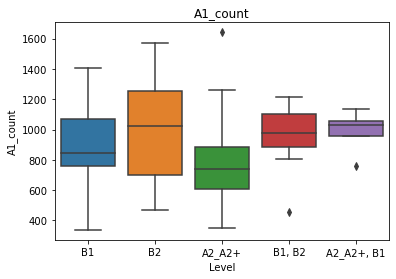

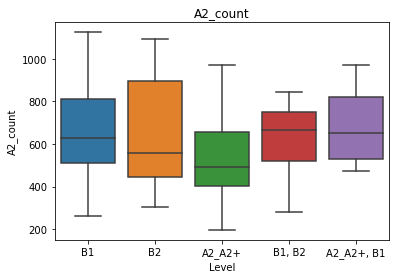

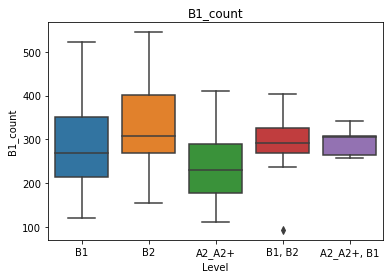

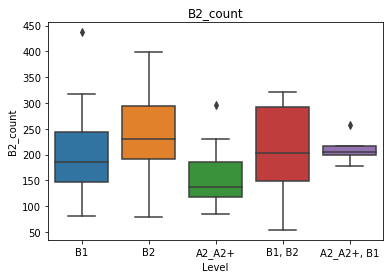

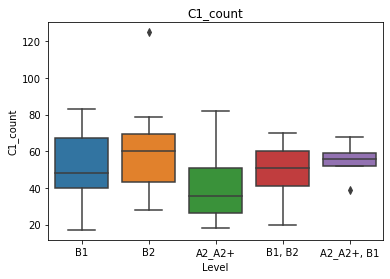

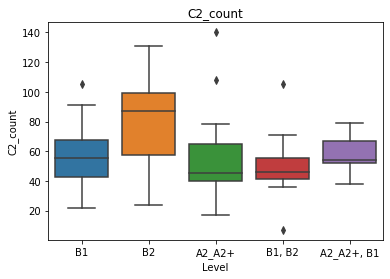

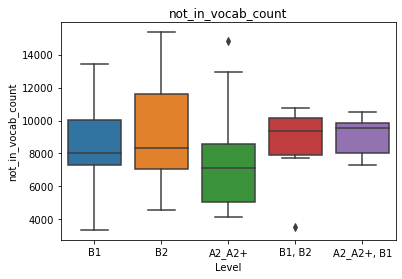

In [41]:
for col in ['A1_count','A2_count','B1_count','B2_count','C1_count','C2_count','not_in_vocab_count']:
    sns.boxplot(data=df,x='Level',y=col).set_title(col)
    plt.show()

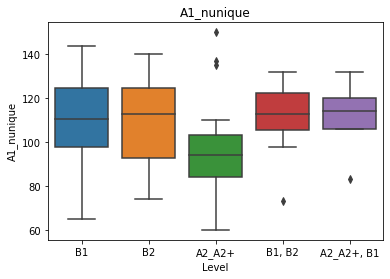

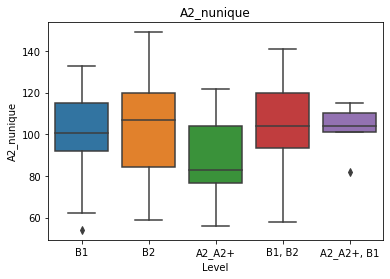

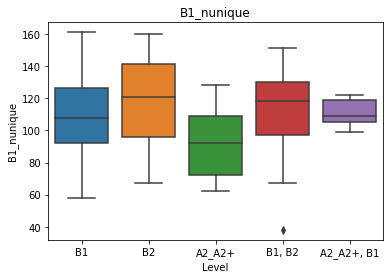

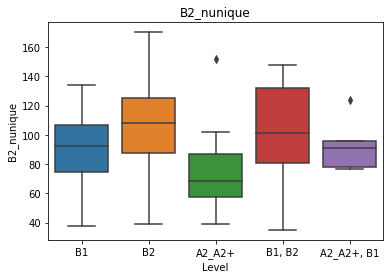

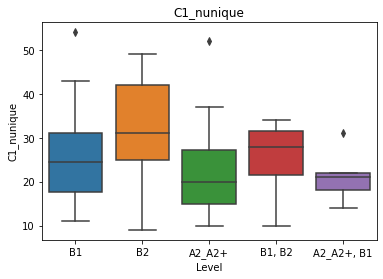

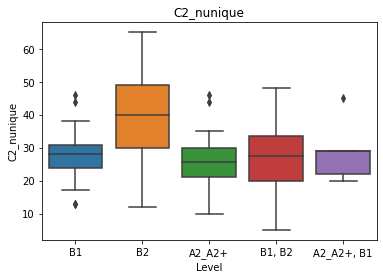

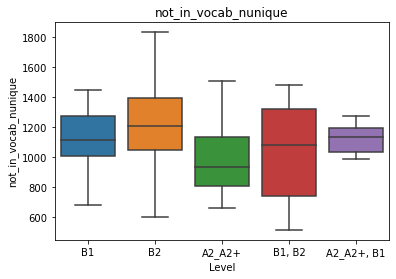

In [42]:
for col in ['A1_nunique','A2_nunique','B1_nunique','B2_nunique','C1_nunique','C2_nunique','not_in_vocab_nunique']:
    sns.boxplot(data=df,x='Level',y=col).set_title(col)
    plt.show()

Распределения отличаются, но надо помнить о кол-ве субтитров каждого уровня.

In [43]:
df['Level'].value_counts()

B1            28
A2_A2+        26
B2            19
B1, B2         8
A2_A2+, B1     5
Name: Level, dtype: int64

Это указание к необходимости выправить таргет.

**Выводы не верны.**
**Строку с кол-вом слов всего и уникальных слов нужно нормализовать.**

Посчитаем общее кол-во слов и уникальных в субтитрах и сравним по уровню.

In [44]:
df['word_count'] = df.loc[:,['A1_count','A2_count','B1_count','B2_count','C1_count','C2_count','not_in_vocab_count']].sum(axis=1)
df['word_nunique'] = df.loc[:,['A1_nunique','A2_nunique','B1_nunique','B2_nunique','C1_nunique','C2_nunique','not_in_vocab_nunique']].sum(axis=1)

In [45]:
df.head()

,Movie,Level,sub_file_name,A1_count,A2_count,B1_count,B2_count,C1_count,C2_count,not_in_vocab_count,A1_nunique,A2_nunique,B1_nunique,B2_nunique,C1_nunique,C2_nunique,not_in_vocab_nunique,word_count,word_nunique
0,10 Cloverfield Lane,B1,10_Cloverfield_lane(2016).srt,487,328,180,133,17,50,4544,80,73,84,62,13,24,680,5739,1016
1,10 things I hate about you,B1,10_things_I_hate_about_you(1999).srt,759,527,243,159,41,53,7393,98,80,114,101,31,38,1096,9175,1558
2,A knight’s tale,B2,A_knights_tale(2001).srt,819,306,268,169,56,45,6189,91,72,97,83,28,35,1058,7852,1464
3,A star is born,B2,A_star_is_born(2018).srt,1310,1082,271,193,28,39,12489,113,94,90,62,14,17,1048,15412,1438
4,Aladdin,A2_A2+,Aladdin(1992).srt,675,471,336,186,52,54,7287,96,92,105,101,35,32,1199,9061,1660


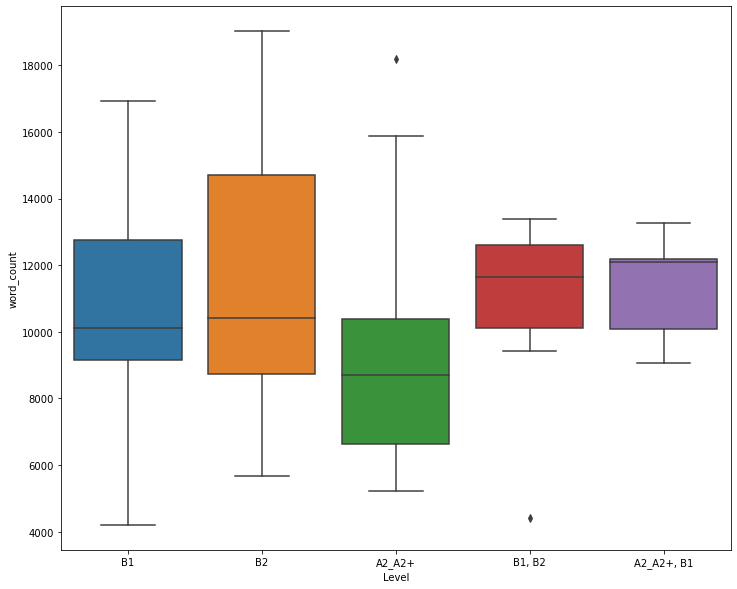

In [46]:
plt.figure(figsize=(12,10))
sns.boxplot(data=df,x='Level',y='word_count')
plt.show()

Можно предположить какую-то предсказательную силу кол-ва слов.  
Помним о малом кол-ве субтитров уровней `B1,B2` `A2_A2+,B1`

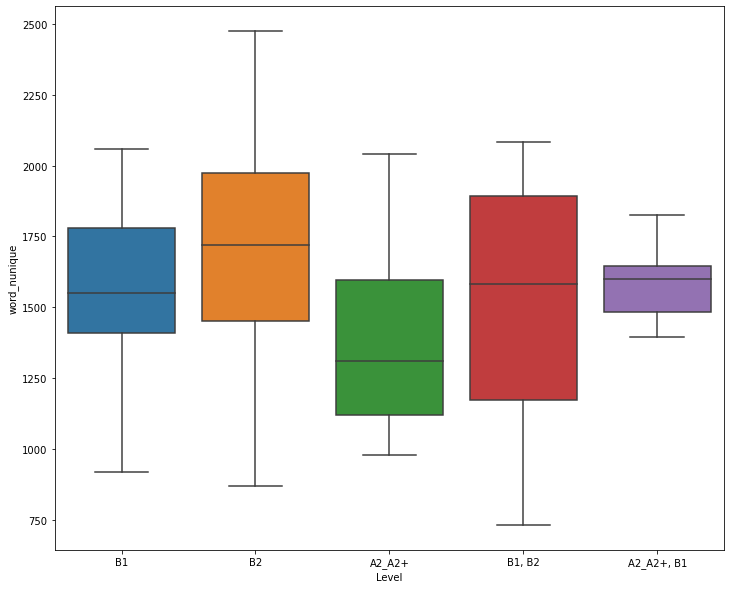

In [47]:
plt.figure(figsize=(12,10))
sns.boxplot(data=df,x='Level',y='word_nunique')
plt.show()

Тут нет какой-то четкой картины и возникает предположение о необходимости сравнить эти распределения каждого уровня с общим распределением слов всех доступных нам субтитров.  
Не факт, что отличия этих уровней являются характеристикой именно уровня, а не в целом, например, кол-ва слов и кол-ва уникальных слов субтитров в целом.  

## Пайплайн для тренировки логистической регрессии `[RAW]`

In [48]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
import pickle
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import cross_val_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SnakeRZR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
def load_data_(path_to_files):
    movie_data = load_files(path_to_files)
    X, y = movie_data.data, movie_data.target

    return X,y

X,y = load_data_('data/Subtitles_multi_binary/B1/')
# print(len(X))
# del X,y

In [50]:
def stem(X):
    documents = []
    
    word_net = WordNetLemmatizer() 

    for sen in range(0, len(X)):
#         Удаление спец символов и цифр
        document = re.sub("(\\W|\\d)","",str(X[sen]))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # stemmin
        document = document.split()

        document = [word_net.lemmatize(word) for word in document]
        document = ' '.join(document)

        documents.append(document)
    return documents

# len(stem(X))

In [51]:
def count_vectorize_(X):
    vectorizer = CountVectorizer(
                            # max_features=1500, 
                             # min_df=5, 
                             # max_df=0.7, 
                             # stop_words=stopwords.words('english'),
                            vocabulary=vocab_for_cvect,
                            ngram_range = (1,1)
                            )
    X = vectorizer.fit_transform(X).toarray()
    return X
# count_vectorize_(X).shape

In [52]:
def tfidf_transform_(X):
    tfidfconverter = TfidfTransformer()
    X = tfidfconverter.fit_transform(X).toarray()
    return X

In [53]:
def pipeline_(path_to_files):
    X, y = load_data_(path_to_files)
    print()
    print('Class balance:')
    print(pd.DataFrame(y).value_counts())
    print()
    
    
    X = stem(X)
        
    X = count_vectorize_(X)
    
    
    # X = tfidf_transform_(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, 
                                                    stratify=y
                                                   )

    logreg = LogisticRegression()
    
    print("cross_val_score(logreg,X,y,cv=5,scoring='roc_auc')")
    cv = cross_val_score(logreg,X,y,cv=5,scoring='roc_auc')
    print(cv)
    print()
    
    logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_test)
    
    print('X_train.shape:', X_train.shape)
    print('X_test.shape:', X_test.shape)
    print()
    print('confusion_matrix(y_test,y_pred)')
    print(confusion_matrix(y_test,y_pred))
    print()
    print('classification_report(y_test,y_pred)')
    print(classification_report(y_test,y_pred))
    print()
    print('accuracy_score(y_test, y_pred)')
    print(accuracy_score(y_test, y_pred))
    print()
    
pipeline_('data/Subtitles_multi_binary/B1//')    # binary
# pipeline_('data/Subtitles_multiclass/')    # multiclass


Class balance:
1    58
0    28
dtype: int64

cross_val_score(logreg,X,y,cv=5,scoring='roc_auc')
[0.5 0.5 0.5 0.5 0.5]

X_train.shape: (51, 4843)
X_test.shape: (35, 4843)

confusion_matrix(y_test,y_pred)
[[ 0 11]
 [ 0 24]]

classification_report(y_test,y_pred)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.69      1.00      0.81        24

    accuracy                           0.69        35
   macro avg       0.34      0.50      0.41        35
weighted avg       0.47      0.69      0.56        35


accuracy_score(y_test, y_pred)
0.6857142857142857



C:\Users\SnakeRZR\Desktop\projects\film_level_estimator\env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SnakeRZR\Desktop\projects\film_level_estimator\env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SnakeRZR\Desktop\projects\film_level_estimator\env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

## Оценка моделей бинарной классификации для каждого уровня `[RAW]`

In [54]:
levels = os.listdir('data/Subtitles_multi_binary/')

In [55]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for level in levels:
        pwd = os.path.abspath(os.getcwd())
        path_to_level = os.path.join(pwd,r'data\Subtitles_multi_binary')
        path_to_level = os.path.join(path_to_level, level)
        print(level)
        print('Path to level:')
        print(path_to_level)
        pipeline_(path_to_level)

A2_A2+
Path to level:
C:\Users\SnakeRZR\Desktop\projects\film_level_estimator\data\Subtitles_multi_binary\A2_A2+

Class balance:
1    60
0    26
dtype: int64

cross_val_score(logreg,X,y,cv=5,scoring='roc_auc')
[0.5 0.5 0.5 0.5 0.5]

X_train.shape: (51, 4843)
X_test.shape: (35, 4843)

confusion_matrix(y_test,y_pred)
[[ 0 11]
 [ 0 24]]

classification_report(y_test,y_pred)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.69      1.00      0.81        24

    accuracy                           0.69        35
   macro avg       0.34      0.50      0.41        35
weighted avg       0.47      0.69      0.56        35


accuracy_score(y_test, y_pred)
0.6857142857142857

A2_A2+, B1
Path to level:
C:\Users\SnakeRZR\Desktop\projects\film_level_estimator\data\Subtitles_multi_binary\A2_A2+, B1

Class balance:
1    81
0     5
dtype: int64

cross_val_score(logreg,X,y,cv=5,scoring='roc_auc')
[0.5 0.5 0.5 0.5 0.5]

X_trai